# بسم الله الرحمن الرحيم


# About Dataset


Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions. so developping models and methods to predict and test the potability of water for human consummation is of huge benefits.

In [66]:
import pandas as pd
import seaborn as sns
import dtale 
import missingno as msn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
 

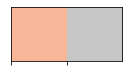

In [2]:
sequential_colors = sns.color_palette("RdGy",2)
sns.palplot(sequential_colors)

In [3]:
data={"1. pH value":"""recommended  pH from 6.5 to 8.5""","2. Hardness":"The capacity of water to precipitate soap caused by Calcium and Magnesium","3. Total dissolved solids - TDS":"Desirable limit is 500 mg/l and maximum 1000 mg/l ","4. Chloramines":"up to 4 milligrams per liter (mg/L or 4 ppm) are considered safe","5. Sulfate":"from 3 to 30 mg/L in most freshwater supplies","6. Conductivity":"not exceeded 400 μS/cm.","7. Total_Organic_carbon(TOC)":"EPA < 2 mg/L as TOC in treated drinking water, and < 4 mg/Lit in source water","8. Trihalomethanes":"up to 80 ppm is considered safe","9. Turbidity":"WHO recommended value of 5.00 NTU.","10. Potability":"Indicates if water is safe for human consumption"}

In [4]:
dataset=pd.DataFrame(data,index=["limits"])
dataset

,1. pH value,2. Hardness,3. Total dissolved solids - TDS,4. Chloramines,5. Sulfate,6. Conductivity,7. Total_Organic_carbon(TOC),8. Trihalomethanes,9. Turbidity,10. Potability
limits,recommended pH from 6.5 to 8.5,The capacity of water to precipitate soap caus...,Desirable limit is 500 mg/l and maximum 1000 m...,up to 4 milligrams per liter (mg/L or 4 ppm) a...,from 3 to 30 mg/L in most freshwater supplies,not exceeded 400 μS/cm.,"EPA < 2 mg/L as TOC in treated drinking water,...",up to 80 ppm is considered safe,WHO recommended value of 5.00 NTU.,Indicates if water is safe for human consumption


# 1- Get The Data

In [5]:
Water_Ch = pd.read_csv("C:\\Machine Learning\\Projects\\Water Potability\\water_potability.csv")

# 2- Take a look at the Data structure 

In [6]:
Water_Ch.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


In [7]:
d=dtale.show(Water_Ch)
d.open_browser()

2021-08-03 21:18:27,795 - INFO     - NumExpr defaulting to 8 threads.


pH value

In [9]:
Water_ph=Water_Ch[(Water_Ch.ph<6.5) | (Water_Ch.ph>8.5)]
outlimit_ph=pd.Series(Water_ph["Potability"].value_counts())
pd.DataFrame(outlimit_ph)

,Potability
0,939
1,518


pH is outlimits but still some values give potability indication so we will reclassify it 

In [10]:
Water_Ch.loc[~Water_Ch.ph.between(6.5, 8.5), 'Potability'] = 0

In [11]:
Water_ph=Water_Ch[(Water_Ch.ph<6.5) | (Water_Ch.ph>8.5)]
outlimit_ph=pd.Series(Water_ph["Potability"].value_counts())
pd.DataFrame(outlimit_ph)

,Potability
0,1457


Hardness

In [12]:
Water_Hardness=Water_Ch.loc[(Water_Ch.Hardness<=500)]
outlimit_Hardness=pd.Series(Water_Hardness["Potability"].value_counts())
pd.DataFrame(outlimit_Hardness)

,Potability
0,2693
1,583


Hardness value within the acceptable limits

solids

In [13]:
Water_solids=Water_Ch.loc[(Water_Ch.Solids>1000)]
outlimit_solid=pd.Series(Water_solids["Potability"].value_counts())
pd.DataFrame(outlimit_solid)

,Potability
0,2691
1,583


Although Solids Also is outlimits of WHO but it represent most of data so we can not reclassify it

But in the same time there are strong relation ship between solids and EC as below link


https://www.researchgate.net/figure/Relationship-between-electrical-conductivity-EC-and-total-dissolved-solids-TDS_fig10_227328358

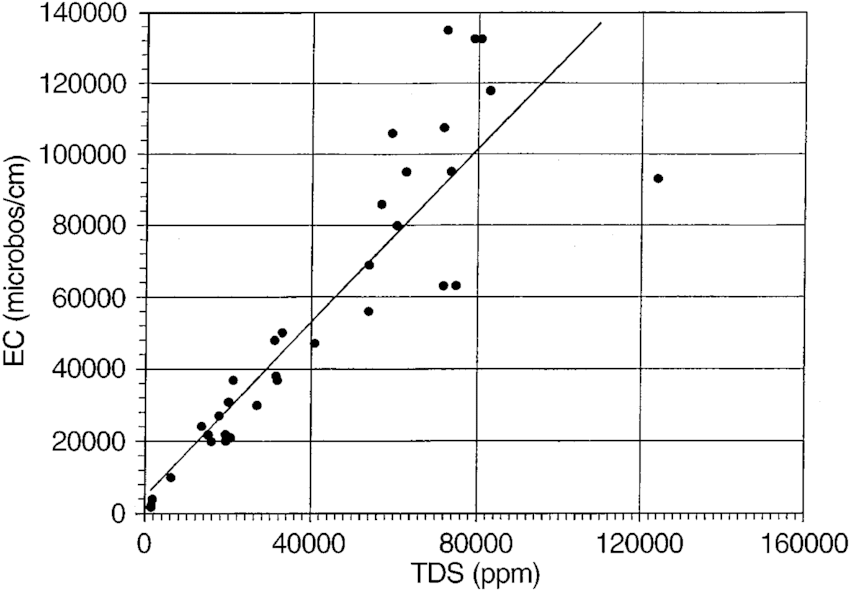

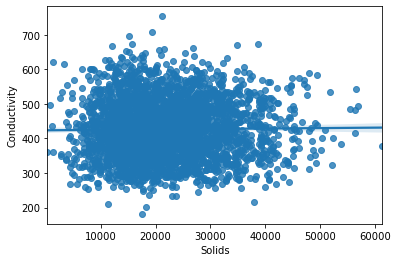

In [14]:
TDS_EC_relation = sns.regplot(x="Solids", y="Conductivity", data=Water_Ch)

so we can use EC to get our model

In [15]:
Water_Ch=Water_Ch.drop(["Solids"],axis=1)

In [16]:
Water_Ch.columns

Index(['ph', 'Hardness', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

Conductivity

In [17]:
Water_Conductivity=Water_Ch[(Water_Ch.Conductivity>400)]
outlimit_Conductivity=pd.Series(Water_Conductivity["Potability"].value_counts())
pd.DataFrame(outlimit_Conductivity)

,Potability
0,1608
1,354


EC is indication for solids also so we reclassify all wronge values according to WHO recommendations

In [18]:
Water_Ch.loc[(Water_Ch.Conductivity>400),"Potability"]=0

In [19]:
Water_Conductivity=Water_Ch[(Water_Ch.Conductivity>400)]
outlimit_Conductivity=pd.Series(Water_Conductivity["Potability"].value_counts())
pd.DataFrame(outlimit_Conductivity)

,Potability
0,1962


Chloramine

In [21]:
Water_Chloramines=Water_Ch[Water_Ch.Chloramines>4]
outlimit_Chloramines=pd.Series(Water_Chloramines["Potability"].value_counts())
pd.DataFrame(outlimit_Chloramines)

,Potability
0,2964
1,223


Sulfate

In [22]:
Water_Sulfate=Water_Ch[(Water_Ch.Sulfate<3) | (Water_Ch.Sulfate>30)]
outlimit_Sulfate=pd.Series(Water_Sulfate["Potability"].value_counts())
pd.DataFrame(outlimit_Sulfate)

,Potability
0,2316
1,179


Organic_carbon	

In [23]:
Water_Organic_carbon=Water_Ch[Water_Ch.Organic_carbon>2]
outlimit_Organic_carbon=pd.Series(Water_Organic_carbon["Potability"].value_counts())
pd.DataFrame(outlimit_Organic_carbon)

,Potability
0,3047
1,229


6 samples would not pass test according to US EPA, where there is no international recommendations for it so we will keep it  

Trihalomethanes

In [25]:
Water_Trihalomethanes=Water_Ch[Water_Ch.Trihalomethanes>80]
outlimit_Trihalomethanes=pd.Series(Water_Trihalomethanes["Potability"].value_counts())
pd.DataFrame(outlimit_Trihalomethanes)

,Potability
0,570
1,32


Trihalomethanes is inlimits defined by WHO 

Turbidity

In [26]:
Water_Turbidity=Water_Ch[Water_Ch.Turbidity!=5]
outlimit_Turbidity=pd.Series(Water_Turbidity["Potability"].value_counts())
pd.DataFrame(outlimit_Turbidity)

,Potability
0,3047
1,229


Turbidity classified correctly according to WHO

In [28]:
Water_Ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Chloramines      3276 non-null   float64
 3   Sulfate          2495 non-null   float64
 4   Conductivity     3276 non-null   float64
 5   Organic_carbon   3276 non-null   float64
 6   Trihalomethanes  3114 non-null   float64
 7   Turbidity        3276 non-null   float64
 8   Potability       3276 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 230.5 KB


In [29]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3276)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

,missing,% of missing
ph,491,14.99
Hardness,0,0.00
Chloramines,0,0.00
Sulfate,781,23.84
Conductivity,0,0.00
Organic_carbon,0,0.00
Trihalomethanes,162,4.95
Turbidity,0,0.00
Potability,0,0.00


so we have null values with ph by 491 record, with Sulfate by 781 and for Trihalomethanes by 162 record

<AxesSubplot:>

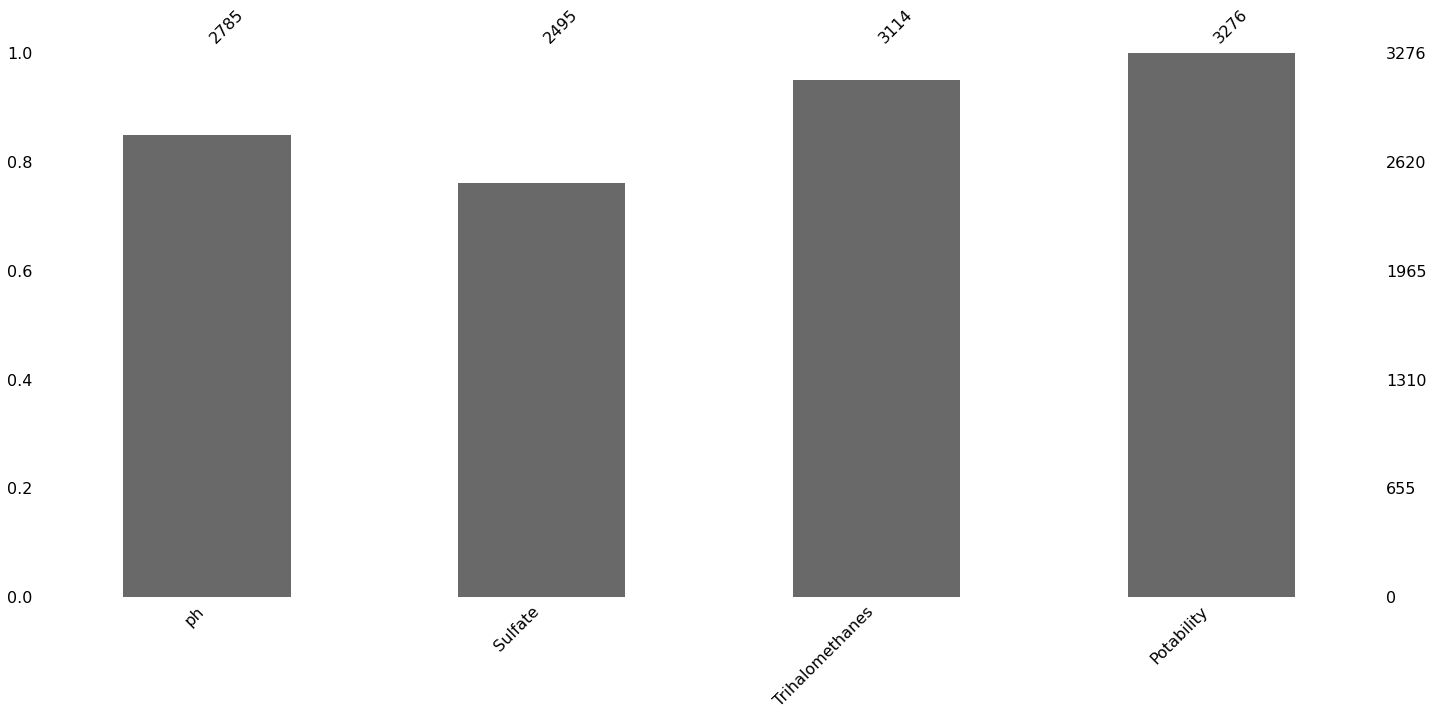

In [30]:
msn.bar(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]])

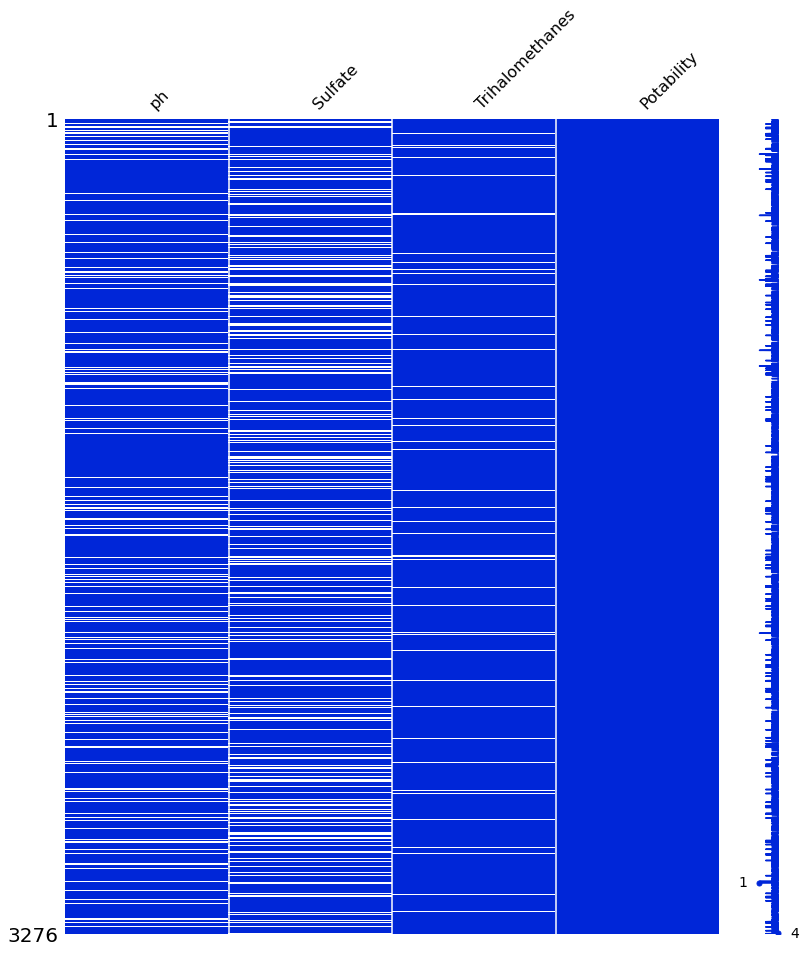

In [31]:
msn.matrix(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]],n=0,p=0,sort=None,figsize=(13,15),width_ratios=(15, 1),color=(0,0.15,0.85),fontsize=16,labels=None,sparkline=True,inline=True,freq=None,ax=None)

<AxesSubplot:>

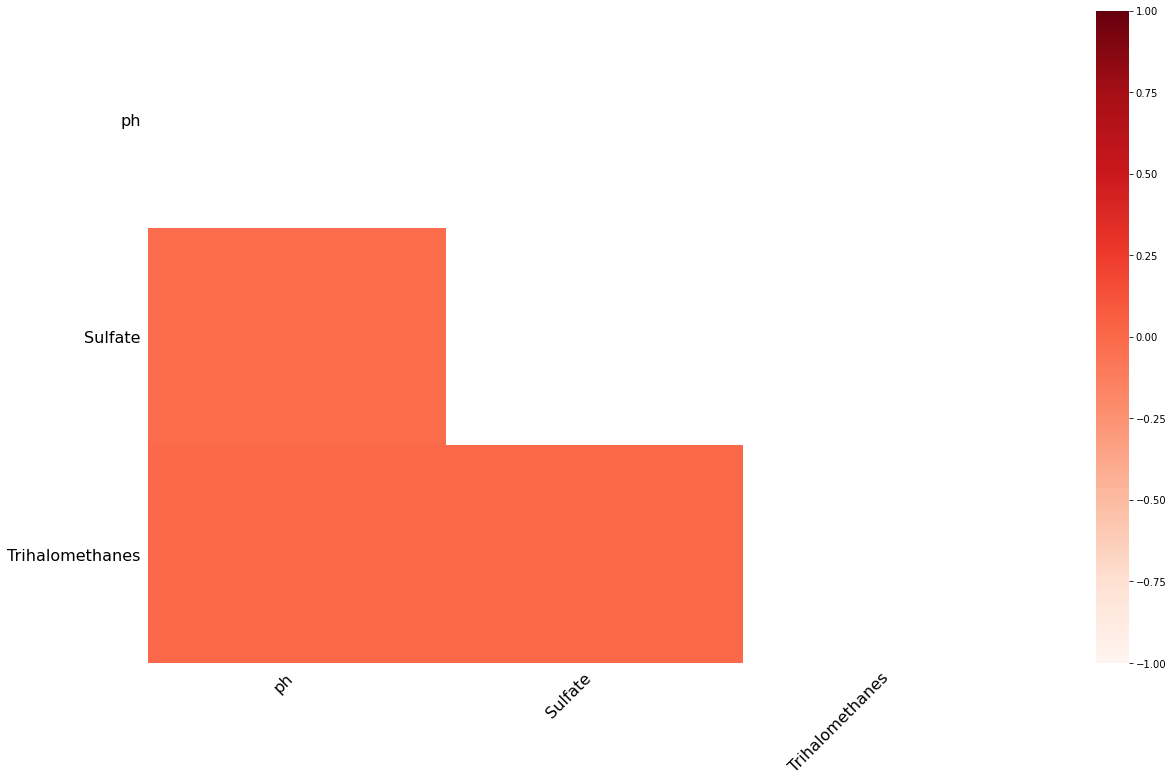

In [32]:
msn.heatmap(Water_Ch[["ph","Sulfate","Trihalomethanes","Potability"]],cmap="Reds")

we can drop the null values from Trihalomethanes while it only represent ~5% of the data 

In [33]:
Water_Ch=Water_Ch.dropna(subset=["Trihalomethanes"])
Water_Ch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 3275
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2649 non-null   float64
 1   Hardness         3114 non-null   float64
 2   Chloramines      3114 non-null   float64
 3   Sulfate          2373 non-null   float64
 4   Conductivity     3114 non-null   float64
 5   Organic_carbon   3114 non-null   float64
 6   Trihalomethanes  3114 non-null   float64
 7   Turbidity        3114 non-null   float64
 8   Potability       3114 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 243.3 KB


In [34]:
pd.DataFrame(Water_Ch[Water_Ch["Potability"]==0].Potability.value_counts())

,Potability
0,2897


In [35]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3114)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

,missing,% of missing
ph,465,14.93
Hardness,0,0.00
Chloramines,0,0.00
Sulfate,741,23.80
Conductivity,0,0.00
Organic_carbon,0,0.00
Trihalomethanes,0,0.00
Turbidity,0,0.00
Potability,0,0.00


we still have large null percentage for Sulfate 23.80%, pH 14.93% 

Now We can search for relationship between attributes to solve missing data problem

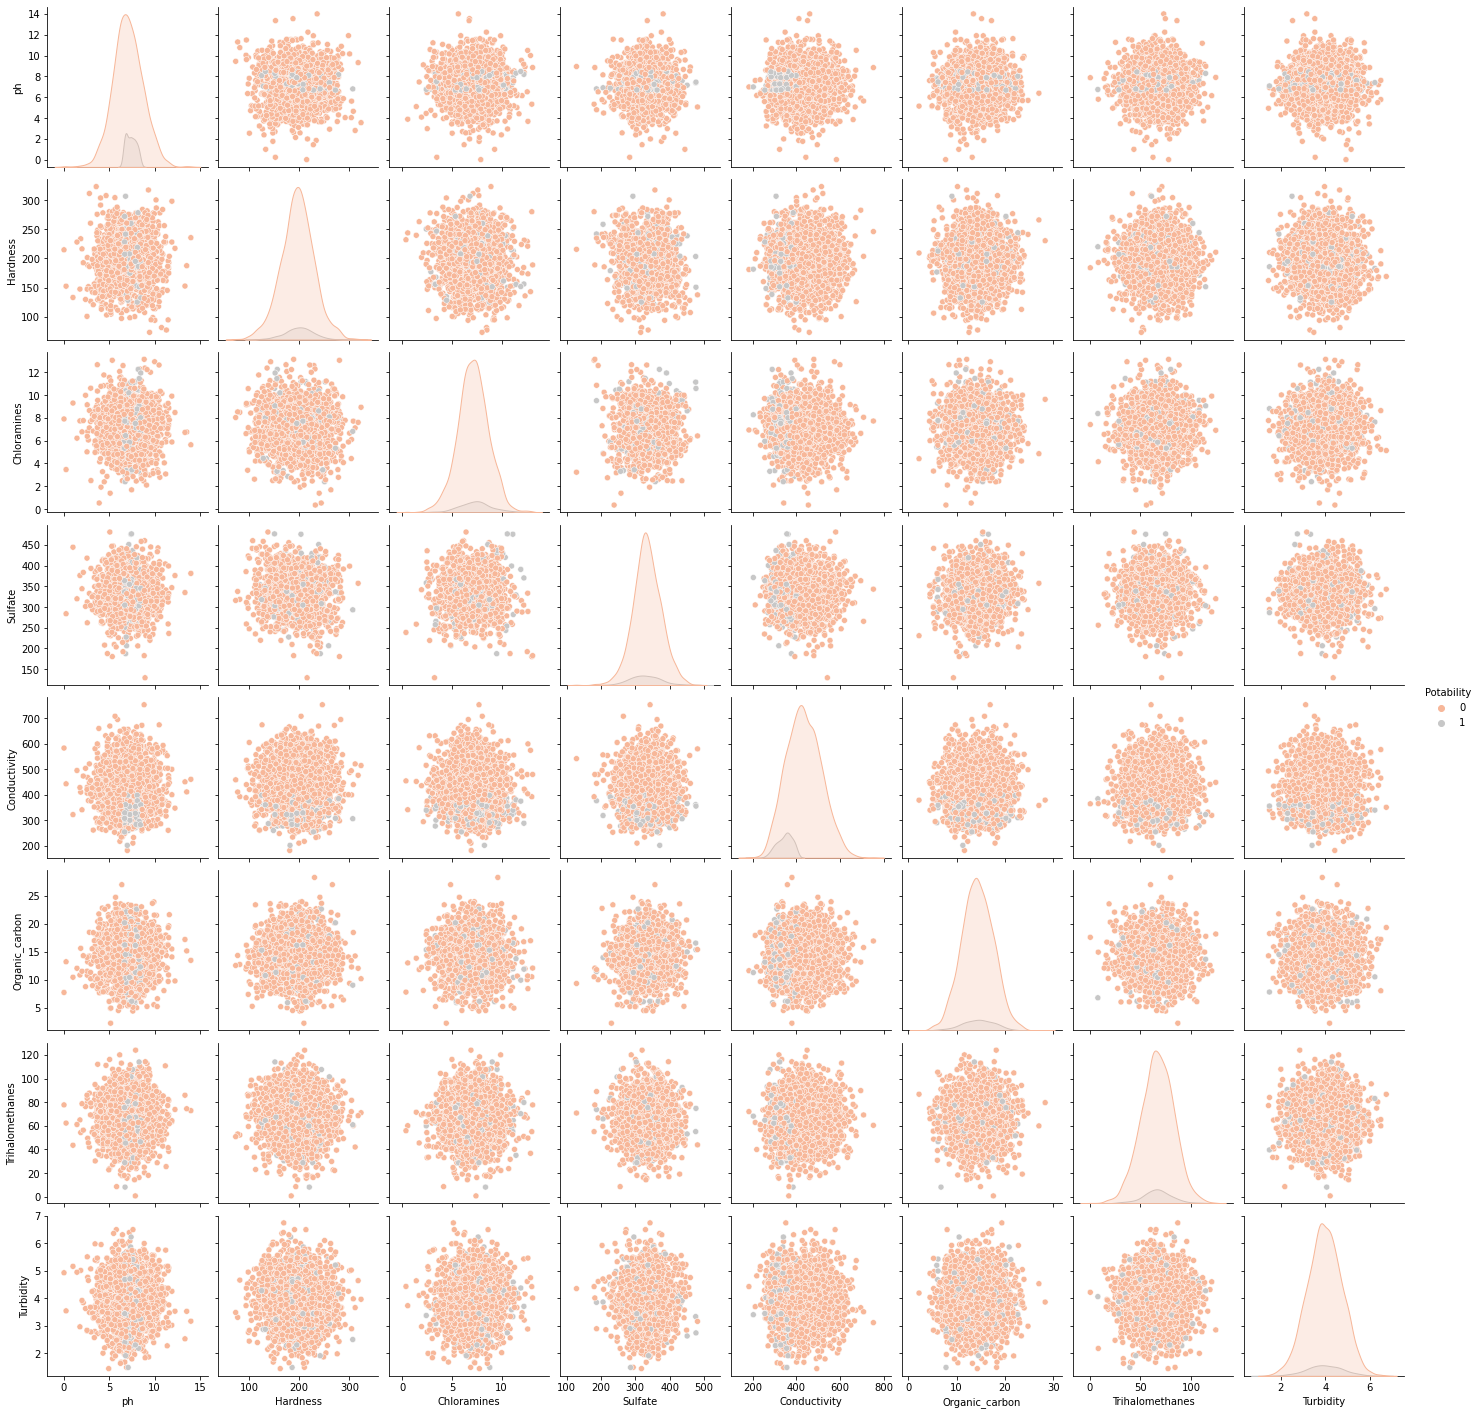

In [36]:
sns.pairplot(Water_Ch, hue="Potability",palette=sequential_colors)

<AxesSubplot:>

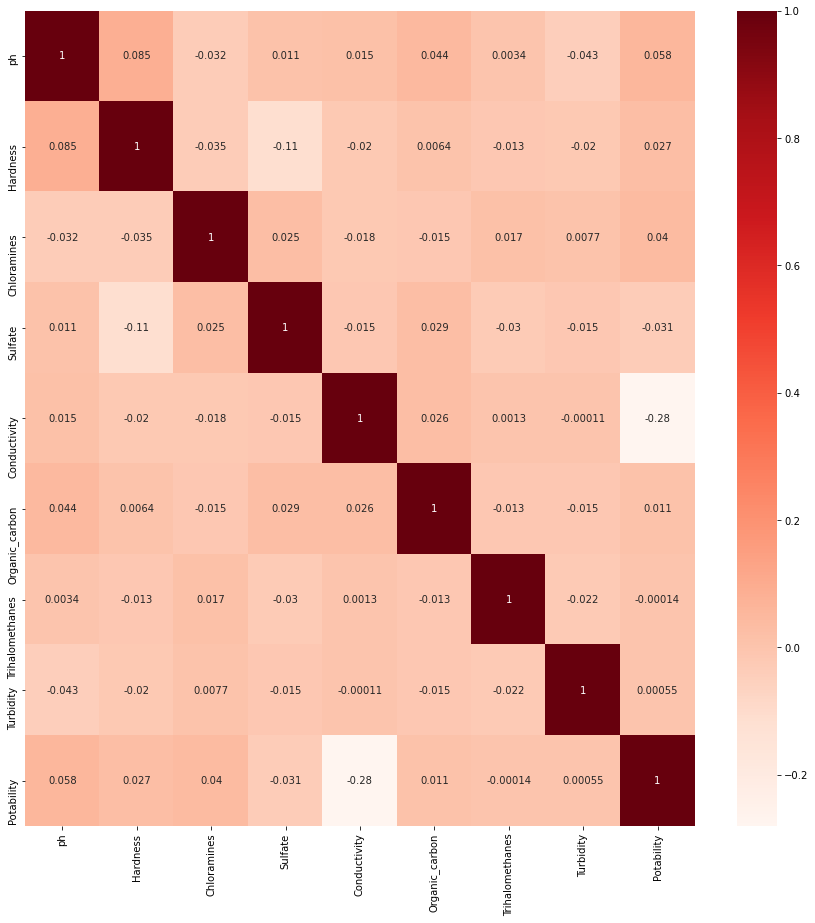

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(Water_Ch.corr(),annot=True,cmap="Reds")

There is no Linear correlation between attributes so we can not use any one to represent the other or to use it to fill th Null values

filling Nan with mean for pH values

In [42]:
pH_nan_1 = Water_Ch.query('Potability == 1')['ph'][Water_Ch['ph'].isna()].index
Water_Ch.loc[pH_nan_1,'ph'] = Water_Ch.query('Potability == 1')['ph'][Water_Ch['ph'].notna()].mean()

pH_nan_0 = Water_Ch.query('Potability == 0')['ph'][Water_Ch['ph'].isna()].index
Water_Ch.loc[pH_nan_0,'ph'] = Water_Ch.query('Potability == 0')['ph'][Water_Ch['ph'].notna()].mean()

filling Nan with mean for Sulfate values

In [43]:
Sulfate_nan_1=Water_Ch.query("Potability==1")["Sulfate"][Water_Ch["Sulfate"].isna()].index
Water_Ch.loc[Sulfate_nan_1,"Sulfate"]=Water_Ch.query("Potability==1")["Sulfate"][Water_Ch["Sulfate"].notna()].mean()
Sulfate_nan_0=Water_Ch.query("Potability==0")["Sulfate"][Water_Ch["Sulfate"].isna()].index
Water_Ch.loc[Sulfate_nan_0,"Sulfate"]=Water_Ch.query("Potability==0")["Sulfate"][Water_Ch["Sulfate"].notna()].mean()

In [44]:
missing={"missing":Water_Ch.isnull().sum(),"% of missing":round(((Water_Ch.isnull().sum()/3114)*100),2)}
Missing_data=pd.DataFrame(missing)
Missing_data

,missing,% of missing
ph,0,0.0
Hardness,0,0.0
Chloramines,0,0.0
Sulfate,0,0.0
Conductivity,0,0.0
Organic_carbon,0,0.0
Trihalomethanes,0,0.0
Turbidity,0,0.0
Potability,0,0.0


In [50]:
Potability=pd.Series(Water_Ch["Potability"].value_counts())
pd.DataFrame(Potability)

,Potability
0,2897
1,217


([<matplotlib.patches.Wedge at 0x1a593b8f6d0>,
 [Text(-0.30404951571037253, -1.3665847547796983, 'Non-potable'),
  Text(0.23889599779251042, 1.073745175653293, 'potable')])

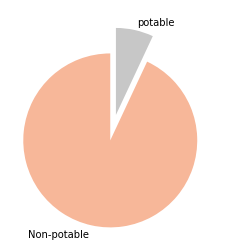

In [46]:
plt.pie(Potability,labels=["Non-potable","potable"],startangle=90,explode=[0.3,0],colors=sequential_colors)

In [73]:
217/(2897+217)

0.06968529222864484

Potability Attribute has a Categorical data with two categories 0 for Non_Potabile water and 1 for Potabile

There are imbalance problem with this Categorical attribute so we will make synthetic Minority oversampling Technique 

In [52]:
x=Water_Ch.drop(["Potability"],axis=1)
y=Water_Ch.Potability

In [53]:
over=SMOTE(sampling_strategy=0.1,random_state=42)
under=RandomUnderSampler(sampling_strategy=0.5)
steps=[("O",over),("U",under)]
pipeline=Pipeline(steps=steps)
x_sm,y_sm=pipeline.fit_resample(x,y)
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.25,random_state =42)

In [76]:
Water_Ch.describe()

,ph,Hardness,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,7.076070,196.410424,7.123720,333.655915,426.625873,14.280721,66.396293,3.965945,0.069685
std,1.461442,32.886366,1.580280,36.161535,80.955832,3.316893,16.175008,0.777174,0.254657
min,0.000000,73.492234,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.274593,176.797029,6.138326,316.844848,366.327185,12.063955,55.844536,3.442882,0.000000
50%,7.052828,197.089829,7.121371,334.002515,421.990447,14.219418,66.622485,3.956464,0.000000
75%,7.865591,216.721079,8.115199,350.367920,482.435328,16.558601,77.337473,4.497705,0.000000
max,14.000000,323.124000,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


array([[<AxesSubplot:title={'center':'ph'}>,
        <AxesSubplot:title={'center':'Hardness'}>,
        <AxesSubplot:title={'center':'Chloramines'}>],
       [<AxesSubplot:title={'center':'Sulfate'}>,
        <AxesSubplot:title={'center':'Conductivity'}>,
        <AxesSubplot:title={'center':'Organic_carbon'}>],
       [<AxesSubplot:title={'center':'Trihalomethanes'}>,
        <AxesSubplot:title={'center':'Turbidity'}>, <AxesSubplot:>]],
      dtype=object)

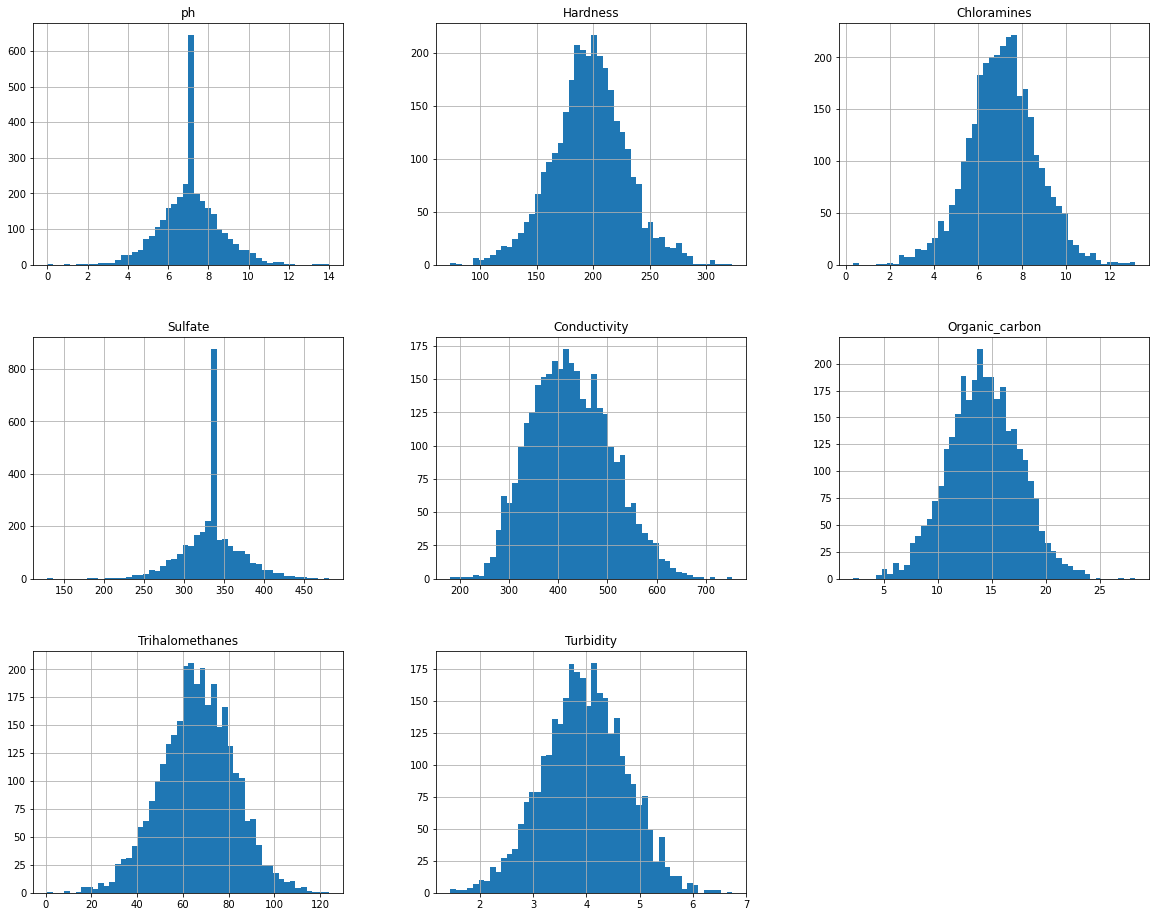

In [52]:
Water_Ch[["ph",
"Hardness",
"Chloramines",
"Sulfate",
"Conductivity"
,"Organic_carbon"
,"Trihalomethanes"
,"Turbidity"]].hist(bins=50, figsize=(20,16))

we make standardization using Robust Scaler to reduce the effect of outliers 

In [54]:
RS=RobustScaler()
x_train=RS.fit_transform(x_train)
x_test=RS.transform(x_test)

Model selection

We will use gridsearch cross validation method to decide on the best parameters

SVC

In [64]:
pipelineSVC = make_pipeline(SVC(random_state=42))
param_grid_svc = [{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0,100],'svc__kernel': ['linear']},{'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],'svc__kernel': ['rbf']}]

gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsSVC.fit(x_train, y_train)

print(gsSVC.best_score_)

print(gsSVC.best_params_)

print('Test accuracy: %.3f' % gsSVC.score(x_test, y_test))

clfSVC = gsSVC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(x_test, y_test))

0.8800000000000001
{'svc__C': 10.0, 'svc__gamma': 0.05, 'svc__kernel': 'rbf'}
Test accuracy: 0.853
Test accuracy: 0.853


In [62]:
svc=SVC(C=10,kernel="rbf",gamma=0.05,random_state=42)
svc.fit(x_train,y_train)
y_pred=svc.predict(x_test)
svc_train_acc=(svc.score(x_train,y_train))*100
svc_test_acc=(svc.score(x_test,y_test))*100
print(svc_test_acc,svc_train_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

85.25345622119815 90.15384615384615
                    0          1  accuracy   macro avg  weighted avg
precision    0.913669   0.743590  0.852535    0.828629      0.858805
recall       0.863946   0.828571  0.852535    0.846259      0.852535
f1-score     0.888112   0.783784  0.852535    0.835948      0.854458
support    147.000000  70.000000  0.852535  217.000000    217.000000


KNN

In [71]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
knn_train_acc=(knn.score(x_train,y_train))*100
knn_test_acc=(knn.score(x_test,y_test))*100
print(knn_train_acc,knn_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

92.61538461538461 79.26267281105991
                    0          1  accuracy   macro avg  weighted avg
precision    0.814815   0.727273  0.792627    0.771044      0.786575
recall       0.897959   0.571429  0.792627    0.734694      0.792627
f1-score     0.854369   0.640000  0.792627    0.747184      0.785218
support    147.000000  70.000000  0.792627  217.000000    217.000000


Decision Tree

In [69]:
pipelineDTC = make_pipeline(DecisionTreeClassifier(criterion='gini',random_state=42))
param_grid_dtc = [{
    'decisiontreeclassifier__max_depth':[2, 3,4,5],
    'decisiontreeclassifier__max_features':[2, 3, 4, 5, 6,7]
}]

gsDTC = GridSearchCV(estimator=pipelineDTC,
                     param_grid = param_grid_dtc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsDTC = gsDTC.fit(x_train, y_train)

print(gsDTC.best_score_)

print(gsDTC.best_params_)

clfDTC = gsDTC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(x_test, y_test))

0.9261538461538462
{'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 7}
Test accuracy: 0.899


In [70]:
dt=DecisionTreeClassifier(max_depth=5,max_features=7,criterion='gini',random_state=42)
dt.fit(x_train,y_train)
y_pred=dt.predict(x_test)
dt_train_acc=(dt.score(x_train,y_train))*100
dt_test_acc=(dt.score(x_test,y_test))*100
print(dt_train_acc, dt_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

94.15384615384616 87.55760368663594
                    0          1  accuracy   macro avg  weighted avg
precision    0.947761   0.759036  0.875576    0.853399      0.886882
recall       0.863946   0.900000  0.875576    0.881973      0.875576
f1-score     0.903915   0.823529  0.875576    0.863722      0.877984
support    147.000000  70.000000  0.875576  217.000000    217.000000


RandomForest

In [67]:
pipelineRFC = make_pipeline(RandomForestClassifier(criterion='gini', random_state=42))
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6,7]
}]

gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

gsRFC = gsRFC.fit(x_train, y_train)

print(gsRFC.best_score_)

print(gsRFC.best_params_)

clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(x_test, y_test))

0.9200000000000002
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 4}
Test accuracy: 0.899


In [68]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=4,max_features=4,random_state=40)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
rf_train_acc=(rf.score(x_train,y_train))*100
rf_test_acc=(rf.score(x_test,y_test))*100
print(rf_train_acc,rf_test_acc)
print(pd.DataFrame(classification_report(y_test,y_pred,labels=[0,1],output_dict=True)))

94.0 87.55760368663594
                    0          1  accuracy   macro avg  weighted avg
precision    0.968750   0.741573  0.875576    0.855162      0.895467
recall       0.843537   0.942857  0.875576    0.893197      0.875576
f1-score     0.901818   0.830189  0.875576    0.866003      0.878712
support    147.000000  70.000000  0.875576  217.000000    217.000000


In [72]:
AL_ACC={"Algorithm":["Support Vector Cl","Kneighbor Cl","Decision Tree Cl","Random Forest"],"train_Accuracy":[svc_train_acc,knn_train_acc,dt_train_acc,rf_train_acc],"test_Accuracy":[svc_test_acc,knn_test_acc,dt_test_acc,rf_test_acc]}
pd.DataFrame(AL_ACC)

,Algorithm,train_Accuracy,test_Accuracy
0,Support Vector Cl,90.153846,85.253456
1,Kneighbor Cl,92.615385,79.262673
2,Decision Tree Cl,94.153846,87.557604
3,Random Forest,94.000000,87.557604


Conclussion 

The best Estimator is Random Forest Estimator with train accuracy equal 94, test accuracy 87.5 